In [1]:
import numpy as np
import matplotlib.pylab as plt
plt.rc('font', family='serif')

from tqdm import tqdm

import torch
import torch.distributions as dist
import zuko

from geobed import BED_discrete
from geobed.fwd_collection.avo import *

In [2]:
# model prior
a_1_model = torch.tensor(2750.0)
d_model   = torch.tensor(500.0 )

n_prior = int(1e6)

a_2_min = torch.tensor([3000.0])
a_2_max = torch.tensor([4500.0])
a_2_prior_dist = dist.Independent(dist.Uniform(a_2_min, a_2_max), 1)
a_2_prior_samples = a_2_prior_dist.sample([n_prior])

print('a_2_prior_sample.shape = ', a_2_prior_samples.shape)

a_2_prior_sample.shape =  torch.Size([1000000, 1])


In [3]:
def forward_function(offset, a_2):
    return calculate_avo(offset, a_1_model, a_2, d_model)

In [5]:
def data_likelihood(samples, **kwargs):

    std_data = 0.05
    
    # same noise realisation for each design point to make optimisation easier
    torch.manual_seed(0)
    data_likelihood = dist.Independent(dist.Normal(samples, torch.tensor(std_data)), 1)
    
    return data_likelihood

In [6]:
n_design_points = 100
design_names = [str(i) for i in range(n_design_points)]
offsets      = torch.linspace(100.0, 3500.0, n_design_points)

design_dicts = {}

for i, name in enumerate(design_names):
    design_dicts[name] = {'index': i, 'offset': offsets[i], 'forward_function': forward_function, 'cost': 1.0}


In [7]:
def constructor_1to1_design(self, name_list, n_samples):
    
    design_dicts_list = [self.design_dicts[n] for n in name_list]
    data = torch.zeros((n_samples, len(name_list), 1))
                
    for i, d_meta in enumerate(design_dicts_list):
        data[:, i, :] = d_meta['forward_function'](d_meta['offset'], self.prior_samples[:n_samples])

    return data.flatten(start_dim=-2)

In [8]:
from geobed import BED_discrete

BED_class = BED_discrete(
    design_dicts, data_likelihood,
    prior_samples=a_2_prior_samples, prior_dist=a_2_prior_dist,
    design2data=constructor_1to1_design)

# Gaussian Mixture Model

In [39]:
# a lot more complicated than necessary since I had to reimplement zuko.flows.FlowModule since dill cant handle abc abstract classes

class GMM_guide(torch.nn.Module):
    def __init__(self, data_samples, K=1):
        data_mean = torch.mean(data_samples, dim=0)
        data_std = torch.std(data_samples, dim=0)
        features = data_samples.shape[-1]
    
        super().__init__()
    
        self.base = zuko.flows.GMM(features=features, components=K)
    
        self.transforms = [zuko.flows.Unconditional(dist.AffineTransform, -data_mean/data_std, 1/data_std, buffer=True),]# buffer=True excludes the parameters from the optimization
    
    def forward(self):
                
        transform = zuko.transforms.ComposedTransform(*(t(None) for t in self.transforms))

        base = self.base(None)

        return zuko.flows.NormalizingFlow(transform, base)
        
    def log_prob(self, x):
                
        out = self.forward().log_prob(x)        
        return out
    
    def sample(self, n_samples):
        
        shape = torch.Size([n_samples])
        return self.forward().sample(shape) 

In [40]:
N = int(1e5)
M = int(1e5)
n_batch = 100
n_epochs = 10

design =['25', '60']
print(design_dicts[design[0]]['offset'], design_dicts[design[1]]['offset'])

eig, info = BED_class.calculate_eig(
    design=design,
    method='variational_marginal',
    method_kwargs=
    {'guide': GMM_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'K':20},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
#      'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-3},
     'scheduler': None,
     'scheduler_kwargs': {},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': True,
     }
)

tensor(958.5859) tensor(2160.6062)


Epoch 0/0, Loss: 0.000:   0%|          | 0/10 [00:00<?, ?it/s]

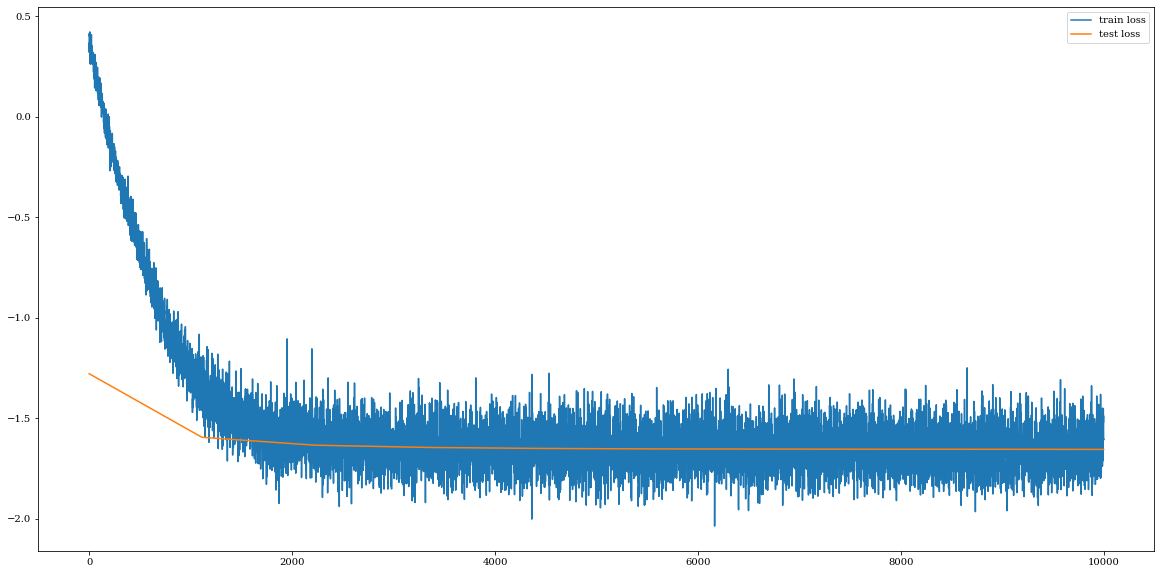

In [41]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['train_loss'])),
        info['train_loss'], label='train loss')
        
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['test_loss'])),
        info['test_loss'], label='test loss')

plt.legend()

plt.show()

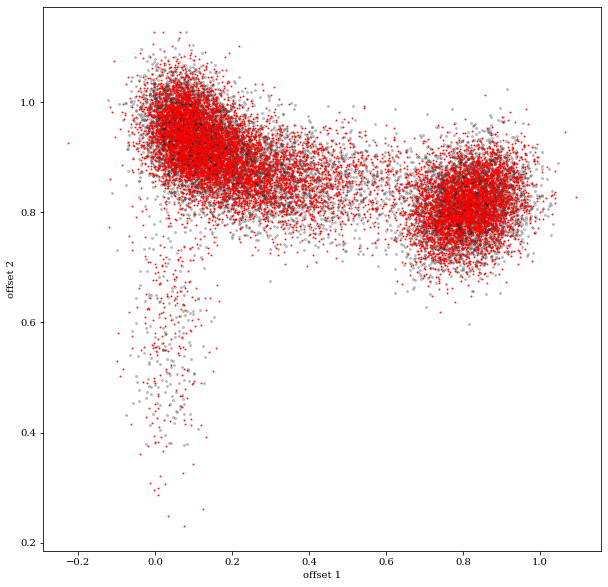

In [42]:
n_visual = int(1e4)

noisy_data = BED_class.get_likelihood_samples(design, n_samples=n_visual)
guide_samples = info['guide']().sample(torch.Size([n_visual]))

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(noisy_data[:, 0], noisy_data[:, 1], s=4, alpha=0.2, color='k')
ax.scatter(guide_samples[:, 0], guide_samples[:, 1], s=1, alpha=0.8, color='r')

ax.set_xlabel('offset 1')
ax.set_ylabel('offset 2')

# ax.set_xlim(0.0, 1.0)
# ax.set_ylim(0.3, 1.0)

plt.show()

# Normalizing Flows

In [131]:
class NF_guide(zuko.flows.NSF):
    def __init__(self, data_samples, *args, **kwargs):
        
        data_mean = torch.mean(data_samples, dim=0)
        data_std = torch.std(data_samples, dim=0)
        features = data_samples.shape[-1]
        
        super().__init__(features=features, *args, **kwargs)
        
        # # if bounds can be changed, box must be -5 to 5 wide
        # self.base = zuko.flows.Unconditional(
        #     zuko.distributions.BoxUniform, -5.0*torch.ones(features), 5.0*torch.ones(features),
        #     buffer=True,)
        
    def log_prob(self, x):
        
        out = self().log_prob(x)
        return out

In [132]:
N = int(1e5)
M = int(1e5)
n_batch = 256
n_epochs = 5

design =['25', '60']
print(design_dicts[design[0]]['offset'], design_dicts[design[1]]['offset'])

eig, info = BED_class.calculate_eig(
    design=design,
    method='variational_marginal',
    method_kwargs=
    {'guide': NF_guide,
     'N': N,
     'M': M,
     'guide_kwargs': {'passes': 2, 'bins':4, 'transforms':10},
     'n_batch': n_batch,
     'n_epochs': n_epochs,
#      'optimizer': torch.optim.Adam,
     'optimizer_kwargs': {'lr': 1e-4},
     'scheduler': None,
     'scheduler_kwargs': {},
     'return_guide': True,
     'return_train_loss': True,
     'return_test_loss': True,
     'progress_bar': True,
     }
)

tensor(958.5859) tensor(2160.6062)


Epoch 0/0, Loss: 0.000:   0%|          | 0/5 [00:00<?, ?it/s]

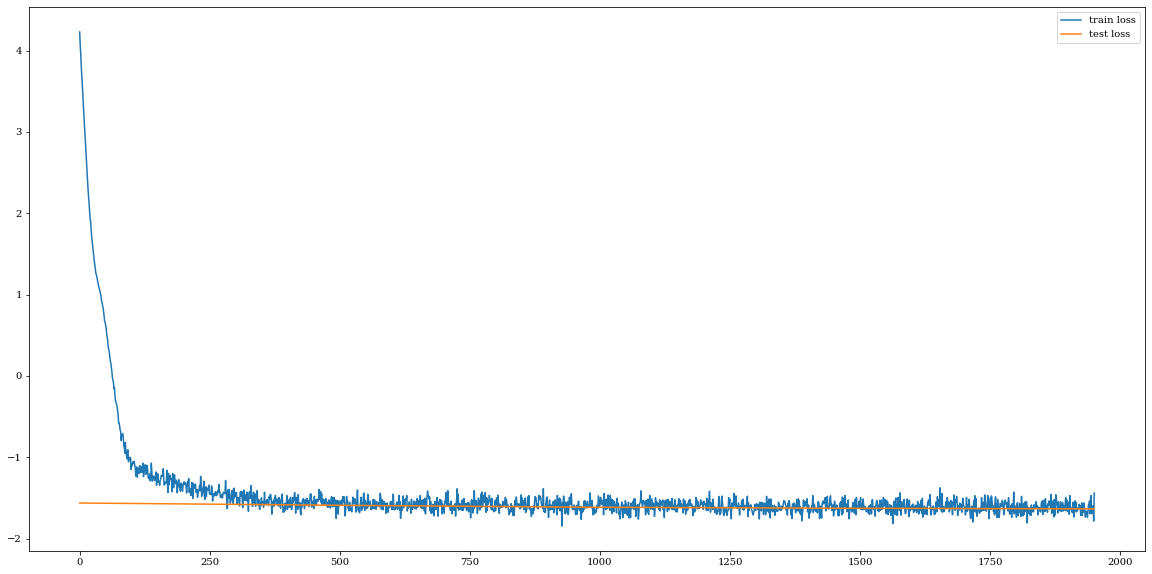

In [133]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['train_loss'])),
        info['train_loss'], label='train loss')
        
ax.plot(np.linspace(0, n_epochs*(M//n_batch), len(info['test_loss'])),
        info['test_loss'], label='test loss')

plt.legend()

plt.show()

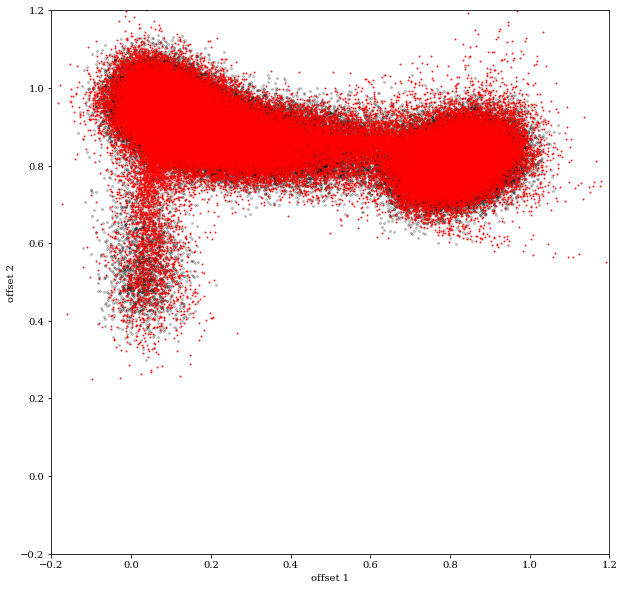

In [136]:
n_visual = int(1e5)

noisy_data = BED_class.get_likelihood_samples(design, n_samples=n_visual)
guide_samples = info['guide']().sample(torch.Size([n_visual]))

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(noisy_data[:, 0], noisy_data[:, 1], s=4, alpha=0.2, color='k')
ax.scatter(guide_samples[:, 0], guide_samples[:, 1], s=1, alpha=0.8, color='r')

ax.set_xlabel('offset 1')
ax.set_ylabel('offset 2')

ax.set_xlim(-0.2, 1.2)
ax.set_ylim(-0.2, 1.2)

plt.show()

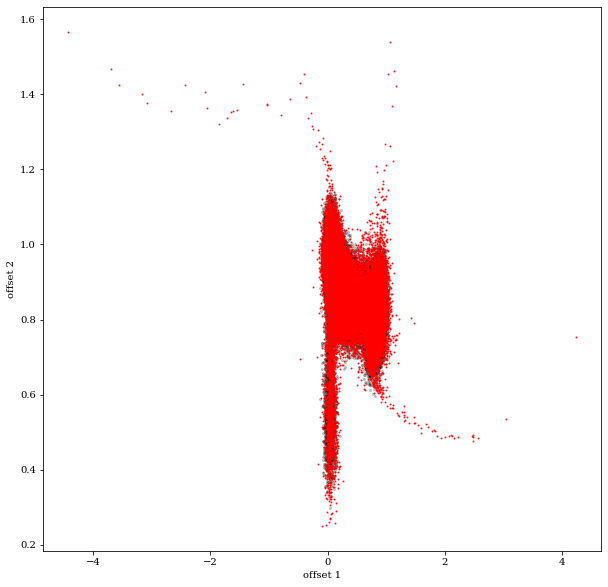

In [138]:
n_visual = int(1e5)

noisy_data = BED_class.get_likelihood_samples(design, n_samples=n_visual)
guide_samples = info['guide']().sample(torch.Size([n_visual]))

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(noisy_data[:, 0], noisy_data[:, 1], s=4, alpha=0.2, color='k')
ax.scatter(guide_samples[:, 0], guide_samples[:, 1], s=1, alpha=0.8, color='r')

ax.set_xlabel('offset 1')
ax.set_ylabel('offset 2')

# ax.set_xlim(-0.2, 1.2)
# ax.set_ylim(-0.2, 1.2)

plt.show()